# Test of flagman performance

In this notebook we compare the improvement made by the hybrid model over the baseline.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from movie_lens_lib import *
from visualization import hybrid_vs_baselines_visualization

## Constants

In [2]:
n_movie_clusters = 5
rating_multiplier = 5
year_multiplier = 0.05
weight_genre, weight_cluster, weight_movie = 0.35, 0.45, 0.2
train_size = 0.9
random_state = 42

## Import & Split dataset

In [3]:
ratings_df = pd.read_csv("data/ratings.csv")
movies_df = pd.read_csv("data/movies.csv", index_col="movieId")

X = ratings_df.drop(["rating"], axis=1)
y = ratings_df["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
ratings_train_df = pd.concat([X_train, y_train], axis=1)
ratings_test_df = pd.concat([X_test, y_test], axis=1)

## Preprocess

In [4]:
movies_hot_df = PreProcessingAggregated().transform((movies_df, ratings_train_df))

## Baseline performance
We are going to compare 3 baseline models in this section.

### Naive constant

As the first baseline we predict rating of **2.5** for every pair of USER - MOVIE.

In [5]:
y_pred = np.zeros(y_test.shape[0]) + 2.5
print_stats(naive_baseline_results := get_performance_stats(y_test, y_pred))

MSE: 2.221
MAE: 1.297
ACCURACY: 0.453


### Mean rating over the training set

In [6]:
y_pred = np.zeros(y_test.shape[0]) + y_train.mean()
print_stats(global_mean_baseline_results := get_performance_stats(y_test, y_pred))

MSE: 1.133
MAE: 0.843
ACCURACY: 0.675


### Mean rating for the movie

We have implemented the regressor for this task, and it is put into movie_lens_lib.py

In [7]:
movie_regressor = MovieBasedRegressor().fit(movies_hot_df)
movie_predictions = movie_regressor.predict(X_test, False)
print_stats(movie_regressor_results := get_performance_stats(y_test, movie_predictions))

MSE: 0.932
MAE: 0.745
ACCURACY: 0.727


## Hybrid performance

In [8]:
hybrid_regressor = HybridRegressor(
    movies_hot_df,
    cluster_based_regressor = ClusterBasedRegressor(
        movies_hot_df,
        n_movie_clusters,
        rating_multiplier,
        year_multiplier,
        random_state
    )
).fit(X_train, y_train)

hybrid_predictions = hybrid_regressor.predict(X_test, False)
print_stats(hybrid_results := get_performance_stats(y_test, hybrid_predictions))

MSE: 0.75
MAE: 0.664
ACCURACY: 0.78


## Performance comparison

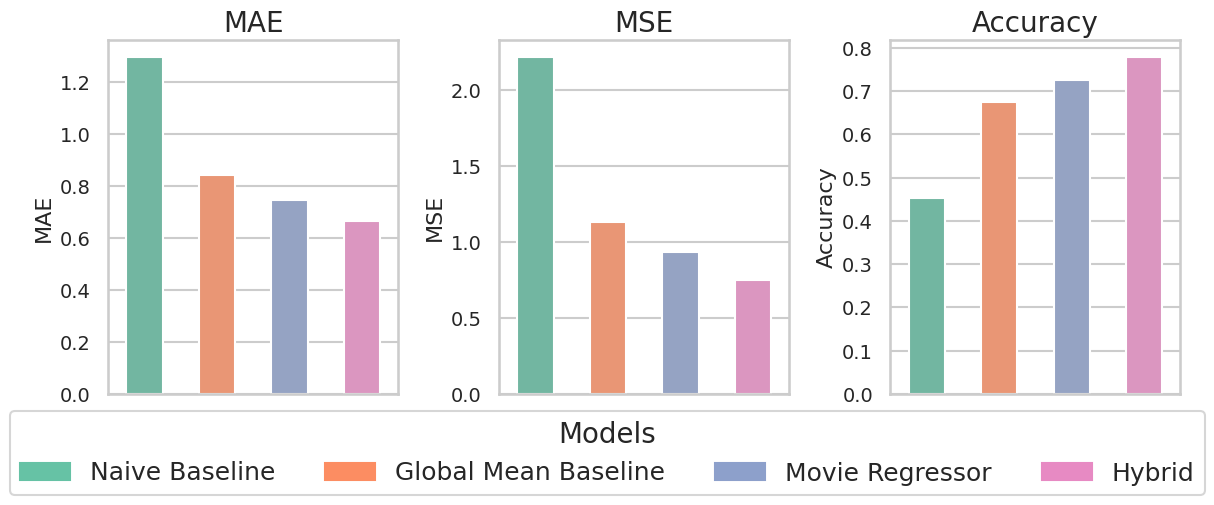

In [9]:
results = {
    "Naive Baseline": naive_baseline_results,
    "Global Mean Baseline": global_mean_baseline_results,
    "Movie Regressor": movie_regressor_results,
    "Hybrid": hybrid_results
}
hybrid_vs_baselines_visualization(results)